``` c++
  231 inline void TVector3::SetXYZ(Double_t xx, Double_t yy, Double_t zz) {
  232    fX = xx;
  233    fY = yy;
  234    fZ = zz;
  235 }
  332 inline void TLorentzVector::SetXYZT(Double_t  x, Double_t  y, Double_t  z, Double_t t) {
  333    fP.SetXYZ(x, y, z);
  334    SetT(t);
  335 }
  336 
  337 inline void TLorentzVector::SetPxPyPzE(Double_t px, Double_t py, Double_t pz, Double_t e) {
  338    SetXYZT(px, py, pz, e);
  339 }
  340 
  341 inline void TLorentzVector::SetXYZM(Double_t  x, Double_t  y, Double_t  z, Double_t m) {
  342    if ( m  >= 0 )
  343       SetXYZT( x, y, z, TMath::Sqrt(x*x+y*y+z*z+m*m) );
  344    else
  345       SetXYZT( x, y, z, TMath::Sqrt( TMath::Max((x*x+y*y+z*z-m*m), 0. ) ) );
  346 }
  347 
  348 inline void TLorentzVector::SetPtEtaPhiM(Double_t pt, Double_t eta, Double_t phi, Double_t m) {
  349    pt = TMath::Abs(pt);
  350    SetXYZM(pt*TMath::Cos(phi), pt*TMath::Sin(phi), pt*sinh(eta) ,m);
  351 }
  352 
  353 inline void TLorentzVector::SetPtEtaPhiE(Double_t pt, Double_t eta, Double_t phi, Double_t e) {
  354    pt = TMath::Abs(pt);
  355    SetXYZT(pt*TMath::Cos(phi), pt*TMath::Sin(phi), pt*sinh(eta) ,e);
```

In [1]:
import plotly
import matplotlib.pyplot as plt
import uproot3 as uproot
import awkward as ak
import numpy as np
from tqdm.notebook import tqdm # adds progress bar 

In [97]:
def set_x_y_z_m(x, y, z, m):
    """
    set the p coordinates and mass simultaneously
    """
    if m > 0: 
        return x, y, z, np.sqrt(x**2+y**2+z**2+m**2)
    else: 
        return x, y, z, np.sqrt(np.max([x**2+y**2+z**2+m**2, 0.])) 
                                
def set_pt_eta_phi_m(pt, eta, phi, m):
    """
    construct lorentz vector associated with the generated electron
    """
    trnsvrs_mom = np.abs(pt) 
    x_comp = trnsvrs_mom*np.cos(phi)
    y_comp = trnsvrs_mom*np.sin(phi)
    z_comp = trnsvrs_mom*np.sinh(eta)
    return set_x_y_z_m(x_comp, y_comp, z_comp, m)

def set_pt_eta_phi_e(pt, eta, phi, e):
    """
    construct lorentz vector associated with the reconstructed electron
    """
    trnsvrs_mom = np.abs(pt) 
    x_comp = trnsvrs_mom*np.cos(phi)
    y_comp = trnsvrs_mom*np.sin(phi)
    z_comp = trnsvrs_mom*np.sinh(eta)
    return x_comp, y_comp, z_comp, e

def delta_r1(a, b):
    """
    given two vectors a and b, calculate the distance
    https://github.com/CoffeaTeam/coffea/blob/7dd4f863837a6319579f078c9e
    445c61d9106943/coffea/nanoevents/methods/vector.py#L66
    """
    a = np.array(a)
    b = np.array(b)
    
    delta_phi = (a - b + np.pi) % (2 * np.pi) - np.pi
    dist_vec = np.hypot(a - b, delta_phi)
    dist = np.linalg.norm(dist_vec)
    return dist

from math import  atan2
def phi(x, deg=False):
    """Return the spherical or cylindrical coordinate phi.
    Parameters
    ----------
    deg : float, optional
        Return the angle in degrees (default is radians).
    """
    phi = atan2(x[1],x[0])
    return phi 

def deltaphi(a, b):
    """Return the phi angle difference, :math:`\\Delta \\phi`, with another Lorentz vector."""
    dphi = phi(a) - phi(b) 
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return dphi

def deltaeta(a, b):
    """Return the pseudorapidity difference, :math:`\\Delta \\eta`, with another Lorentz vector."""
    return a - b

def delta_r(a, b):
    """Return :math:`\\Delta R` the distance in (eta,phi) space with another Lorentz vector, defined as:
    :math:`\\Delta R = \\sqrt{(\\Delta \\eta)^2 + (\\Delta \\phi)^2}`
    """
    a = np.array(a)
    b = np.array(b)
    return np.linalg.norm(np.sqrt(deltaeta(a,b) ** 2 + deltaphi(a,b) ** 2))

In [37]:
ntuple = uproot.open('../hgcalNtuple_1000_1.root')
tree = ntuple['ana/hgc']
tree.show()

event                      (no streamer)              asdtype('>u8')
lumi                       (no streamer)              asdtype('>u4')
run                        (no streamer)              asdtype('>u4')
vtx_x                      (no streamer)              asdtype('>f4')
vtx_y                      (no streamer)              asdtype('>f4')
vtx_z                      (no streamer)              asdtype('>f4')
genpart_eta                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_phi                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_pt                 TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_energy             TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvx                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvy                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvz                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpa

In [99]:
m_electron =  0.000511
# generated parameters are symmetric arrays
generated_energies = np.array(list(tree['gen_energy'].array())).flatten()
gen_pt = np.array(list(tree['gen_pt'].array())).flatten()
gen_eta = np.array(list(tree['gen_eta'].array())).flatten()
gen_phi = np.array(list(tree['gen_phi'].array())).flatten()
# reco parameters are jagged
reconstructed_energies = list(tree['rechit_energy'].array())
rechit_pt = list(tree['rechit_pt'].array())
rechit_eta = list(tree['rechit_eta'].array())
rechit_phi = list(tree['rechit_phi'].array()) 
rechit_layer = list(tree['rechit_layer'].array())


total_e_per_evt = [] 

for gen_idx, row_gen_e  in enumerate(tqdm(generated_energies)):
    # we don't really need the energy per say
    elect_lrntz_vec = set_pt_eta_phi_m(
        gen_pt[gen_idx], gen_eta[gen_idx], gen_phi[gen_idx], m_electron 
    )    
    #print("event:", gen_idx)
    
    summed_cone_e = 0 
    
    for row_rec_e, row_rec_pt, row_rec_eta, row_rec_phi, row_rec_layer in tqdm(zip(
        reconstructed_energies, rechit_pt, rechit_eta, rechit_phi, rechit_layer)):
        
        for rec_idx, rechit_e in tqdm(enumerate(row_rec_e)):
            
            if row_rec_layer[rec_idx] < 29: 
                
                rechit_pt = rechit_e/ np.cosh(row_rec_eta[rec_idx])
                #print(row_rec_eta[rec_idx])
                rechit_lrntz_vec = set_pt_eta_phi_e(
                    rechit_pt, row_rec_eta[rec_idx], row_rec_phi[rec_idx], rechit_e
                ) 
                
                d_r = delta_r(elect_lrntz_vec[0:3],rechit_lrntz_vec[0:3])
                
                if d_r < 0.3:  
                    
                    summed_cone_e += rechit_e 
    
    total_e_per_evt.append(summed_cone_e)
    

  0%|          | 0/800 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [96]:
x = np.array([1,1,1])
np.sqrt(deltaeta(x ,x ) ** 2 + deltaphi(x ,x ) ** 2)

array([0., 0., 0.])

In [ ]:
m_electron =  0.000511
# generated parameters are symmetric arrays
generated_energies = np.array(list(tree['gen_energy'].array())).flatten()
gen_pt = np.array(list(tree['gen_pt'].array())).flatten()
gen_eta = np.array(list(tree['gen_eta'].array())).flatten()
gen_phi = np.array(list(tree['gen_phi'].array())).flatten()
# reco parameters are jagged
reconstructed_energies = list(tree['rechit_energy'].array())
rechit_pt = list(tree['rechit_pt'].array())
rechit_eta = list(tree['rechit_eta'].array())
rechit_phi = list(tree['rechit_phi'].array()) 
rechit_layer = list(tree['rechit_layer'].array())


total_e_per_evt = [] 

for gen_idx, row_gen_e  in enumerate(generated_energies):
    # we don't really need the energy per say
    elect_lrntz_vec = set_pt_eta_phi_m(
        gen_pt[gen_idx], gen_eta[gen_idx], gen_phi[gen_idx], m_electron 
    )    
    print("Summing event:", gen_idx)
    
    summed_cone_e = 0 
    
    for row_rec_e, row_rec_pt, row_rec_eta, row_rec_phi, row_rec_layer in zip(
        reconstructed_energies, rechit_pt, rechit_eta, rechit_phi, rechit_layer):
        
        mask = row_rec_layer < 29
        row_rec_e = row_rec_e[mask]
        row_rec_pt = row_rec_pt[mask]
        row_rec_eta = row_rec_eta[mask]
        row_rec_phi = row_rec_phi[mask] 
        #row_rec_pt = row_rec_pt[mask]
        
        for rec_idx, rechit_e in enumerate(tqdm(row_rec_e)):

            rechit_pt = rechit_e/ np.cosh(row_rec_eta[rec_idx])
            #print(row_rec_eta[rec_idx])
            rechit_lrntz_vec = set_pt_eta_phi_e(
                rechit_pt, row_rec_eta[rec_idx], row_rec_phi[rec_idx], rechit_e
            ) 

            d_r = delta_r(elect_lrntz_vec[0:3],rechit_lrntz_vec[0:3])

            if d_r < 0.3:  
                print(d_r)
                summed_cone_e += rechit_e 

    total_e_per_evt.append(summed_cone_e)
    

Summing event: 0


  0%|          | 0/39106 [00:00<?, ?it/s]

  0%|          | 0/39128 [00:00<?, ?it/s]

  0%|          | 0/39089 [00:00<?, ?it/s]

  0%|          | 0/40460 [00:00<?, ?it/s]

  0%|          | 0/40483 [00:00<?, ?it/s]

In [69]:
reconstructed_energies = list(tree['rechit_energy'].array()) 
#print(reconstructed_energies)
#len(reconstructed_energies)
len(generated_energies)
for element in reconstructed_energies:
    print(element.size)
    
print(len(reconstructed_energies))


44334
44383
44479
45792
45824
44741
45755
44634
46022
43643
45249
44513
46320
43533
46212
43324
42977
43522
46207
43970
46115
44572
46659
45506
44519
43755
45743
45533
45926
43942
44635
45093
45782
44623
45262
44808
46021
45424
46031
44877
44445
44138
45986
44368
44275
44527
46024
43996
42373
45013
45610
45230
46133
43255
45712
44499
46082
43407
44189
43926
45347
45177
46238
43915
46121
43942
45920
44128
46093
43854
45476
40982
44903
44426
46058
43082
45071
44889
46137
44302
46139
45928
44292
44823
44429
44606
44428
43837
46092
45703
46295
45582
45182
42939
46227
45342
44199
44700
44260
45395
46608
45074
44711
44398
45689
44489
44736
46366
44956
43091
45471
43417
46049
45217
45545
44427
45784
45116
44240
45754
44956
44800
44594
45514
46097
43156
46072
45244
44192
43858
44282
45279
44485
44593
47644
45889
46194
42557
45982
44652
46063
45268
44943
45568
44841
45076
45950
43815
42940
44757
46003
45858
44631
43352
44719
42719
45533
43561
45879
45347
45736
44573
45884
44114
46195
44578
4472

In [49]:

reconstructed_energies = list(tree['rechit_layer'].array())
#print(reconstructed_energies)
#len(reconstructed_energies)
len(generated_energies)
for element in reconstructed_energies:
    if (element.size == 39106 ):
        print(element.size)

In [162]:
list(tree['rechit_energy'].array())

[array([0.00808871, 0.09949117, 0.04367905, ..., 0.04419623, 0.05008906,
        0.04124981], dtype=float32),
 array([0.16902466, 0.01454555, 0.0382494 , ..., 0.04155945, 0.04138507,
        0.04124981], dtype=float32),
 array([0.00606653, 0.02143509, 0.01981735, ..., 0.04123025, 0.04124981,
        0.04714264], dtype=float32),
 array([0.01750049, 0.02086597, 0.06529027, ..., 0.04124981, 0.04124981,
        0.04124981], dtype=float32),
 array([0.08548316, 0.05923242, 0.0148081 , ..., 0.04419623, 0.04124981,
        0.04124981], dtype=float32),
 array([0.01481491, 0.01212129, 0.04309792, ..., 0.04712029, 0.04123025,
        0.04124981], dtype=float32),
 array([0.0134681 , 0.0397309 , 0.00875426, ..., 0.04419623, 0.04419623,
        0.04124981], dtype=float32),
 array([0.01077448, 0.01212129, 0.02491599, ..., 0.04419623, 0.04124981,
        0.04124981], dtype=float32),
 array([0.00673096, 0.01144263, 0.07269433, ..., 0.04155945, 0.04729722,
        0.04714264], dtype=float32),
 array([0.

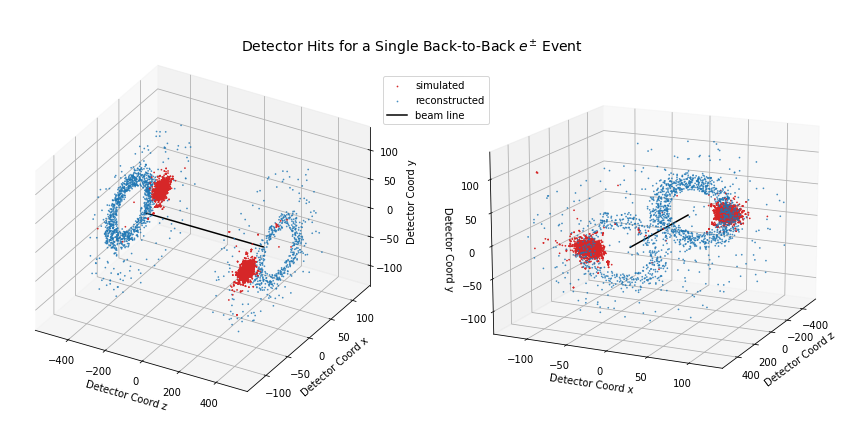

In [105]:
# Note, it is easier to visualize (x, y, z) --> (z, x, y) 
evt_num = 100
fig = plt.figure(figsize=(15,12))
fig.suptitle(r"Detector Hits for a Single Back-to-Back $e^{\pm}$ Event", y = .73, size = 14)

for panel in range (121,123):
    ax = fig.add_subplot(panel, projection='3d')
    ax.scatter(tree['simhit_z'].array()[evt_num], 
               tree['simhit_x'].array()[evt_num], 
               tree['simhit_y'].array()[evt_num],
               label = "simulated",
               color = "tab:red", 
               alpha = 1,
               s = .50)
    mask = np.in1d(tree['rechit_z'].array()[evt_num], tree['simhit_z'].array()[evt_num], invert = True) 
    ax.scatter(tree['rechit_z'].array()[evt_num][mask], 
               tree['rechit_x'].array()[evt_num][mask], 
               tree['rechit_y'].array()[evt_num][mask],
               label = "reconstructed",
               color = "tab:blue",
               alpha = .75,
               s = .55)
    ax.plot([-320., 320.], [0,0], [0,0], color='k', label = "beam line") 
    ax.set_xlabel('Detector Coord z')
    ax.set_ylabel('Detector Coord x')
    ax.set_zlabel('Detector Coord y')
    if panel == 121: 
        ax.set_proj_type('ortho')
    else: 
        ax.view_init(15, 25)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(.45, .71))